In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,  precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import time
torch.manual_seed(42)
np.random.seed(42)

# First Feature Map

In [2]:

# Configuration
n_qubits = 2
input_dim = 2
res = 30  # resolution of x1, x2 grid
X_vals = np.linspace(0, 2 * np.pi, res)
X1, X2 = np.meshgrid(X_vals, X_vals)
inputs = np.stack([X1.ravel(), X2.ravel()], axis=1)


In [3]:

# Encoding
def encoding_layer(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RY(x[0]*x[1], wires=0)
    qml.RY(x[1]*x[0], wires=1)
    
# Variational block
def variational_block(weights):
    for i in range(n_qubits):
        qml.RZ(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RZ(weights[i, 2], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])

# Create circuit
def create_qnode(depth, weights, dev,num_reupload,obs):
    @qml.qnode(dev)
    def circuit(x):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(x)
                count += 1
            variational_block(weights[d])
        return qml.expval(obs)
    return circuit


In [4]:

# Label from circuit
def generate_labels(circuit, X):
    return np.array([1 if circuit(x) > 0 else 0 for x in X])


In [5]:

# Quantum classifier as TorchLayer
def get_torch_model(depth, dev,num_reupload,obs):
    weight_shapes = {"weights": (depth, n_qubits, 3)}

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(inputs)
                count += 1
            for i in range(n_qubits):
                qml.RZ(weights[d, i, 0], wires=i)
                qml.RY(weights[d, i, 1], wires=i)
                qml.RZ(weights[d, i, 2], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])
        return qml.expval(obs)

    return qml.qnn.TorchLayer(circuit, weight_shapes)


In [6]:

# Training loop
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        opt.zero_grad()
        outputs = torch.stack([model(x) for x in X_train])
        loss = loss_fn(outputs, y_train.squeeze())
        loss.backward()
        opt.step()
    return model


In [7]:
def plot_generator_A(generator_labels, title, X=None, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = generator_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, cmap='RdBu', alpha=0.4)
    plt.contour(X1, X2, Z, levels=2, colors='black', linewidths=0.5)

    # Optional: overlay generated class markers on the full grid
    X_flat = X1.ravel(), X2.ravel()
    labels_flat = generator_labels.ravel()
    for cls, marker in zip([0, 1], ['o', 's']):
        idx = labels_flat == cls
        plt.scatter(X_flat[0][idx], X_flat[1][idx], marker=marker, color='black', s=5, alpha=0.3, label=f'Class {cls}')

    # Optional: training points overlay
    if X is not None and train_idx is not None:
        X_train = X[train_idx]
        y_train = generator_labels[train_idx]
        for i, pt in enumerate(X_train):
            marker = 'o' if y_train[i] == 0 else 's'
            plt.scatter(pt[0], pt[1], marker=marker, color='yellow', edgecolor='black', s=40, label="Train point" if i == 0 else None)

    plt.title(title)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:

# Plot contours
def plot_results(generator_labels, predicted_labels, title, X, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = predicted_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, alpha=0.3, cmap='RdBu')
    plt.contour(X1, X2, generator_labels.reshape(res, res), levels=2, colors='black', linewidths=0.5)

    # Plot training points
    if train_idx is not None:
        X_train_pts = X[train_idx]
        y_true = generator_labels[train_idx]
        y_pred = predicted_labels[train_idx]

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)
    if train_idx is None:
        X_train_pts = X
        y_true = generator_labels
        y_pred = predicted_labels

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    plt.show()



In [9]:

# Main experiment

train_idx = np.random.choice(len(inputs), size=300, replace=False)
X_train = torch.tensor(inputs[train_idx], dtype=torch.float32)
test_idx = np.setdiff1d(np.arange(len(inputs)), train_idx)
X_test = torch.tensor(inputs[test_idx], dtype=torch.float32)
depths = {
    "Z0": qml.PauliZ(0),
    "X0": qml.PauliX(0),
    "ZZ": qml.PauliZ(0) @ qml.PauliZ(1),
    "XX": qml.PauliX(0) @ qml.PauliX(1),
    "XZ": qml.PauliX(0) @ qml.PauliZ(1),
    "ZX": qml.PauliZ(0) @ qml.PauliX(1)
    
    }   

results = []


  0%|          | 0/6 [00:00<?, ?it/s]

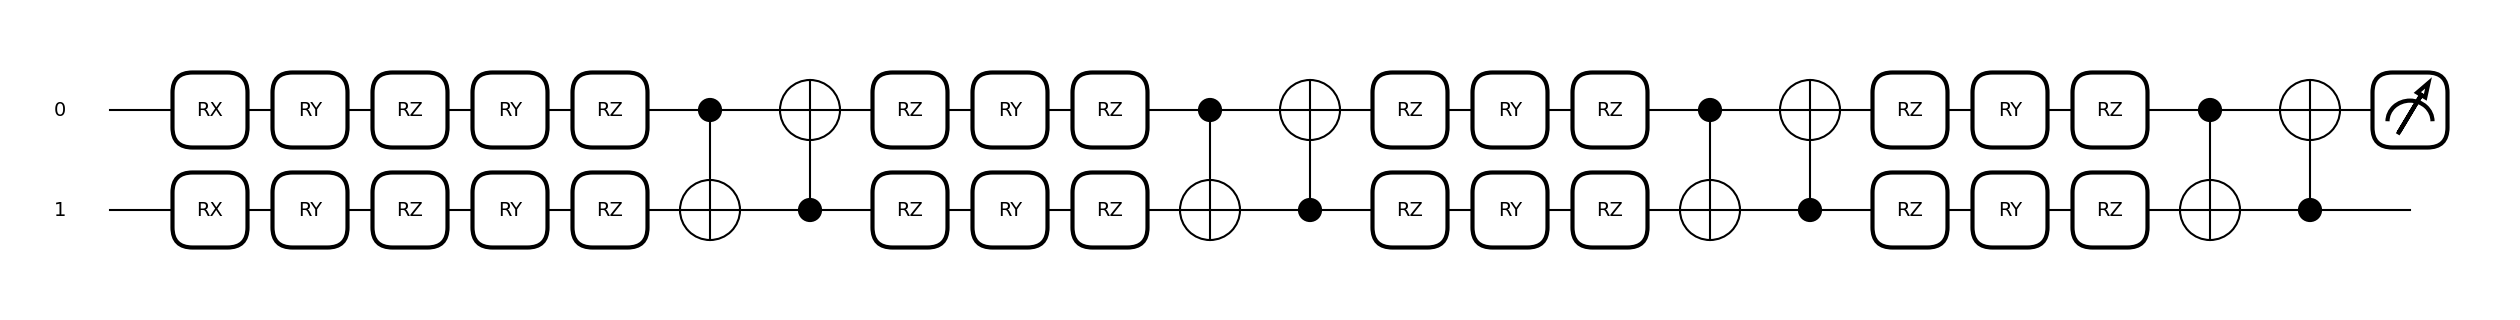

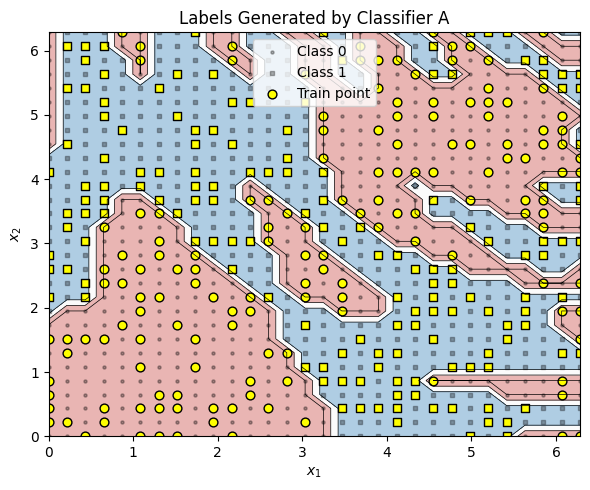

Training B(reupload=Z0) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 252.484313249588


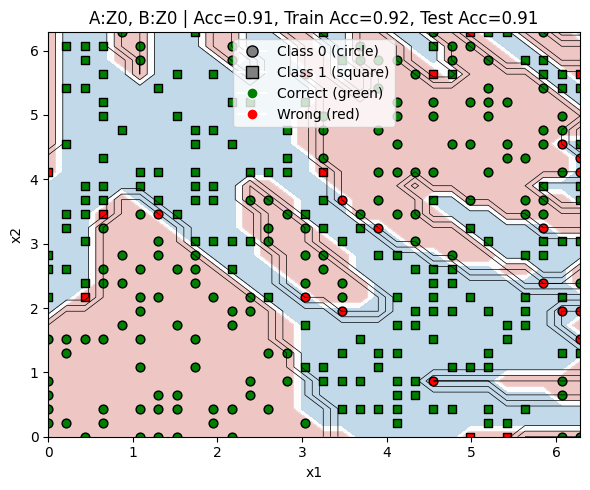

Training B(reupload=X0) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 253.7374894618988


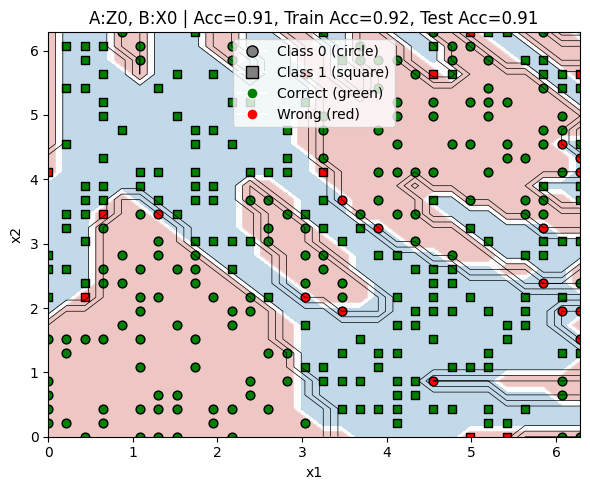

Training B(reupload=ZZ) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 247.10760927200317


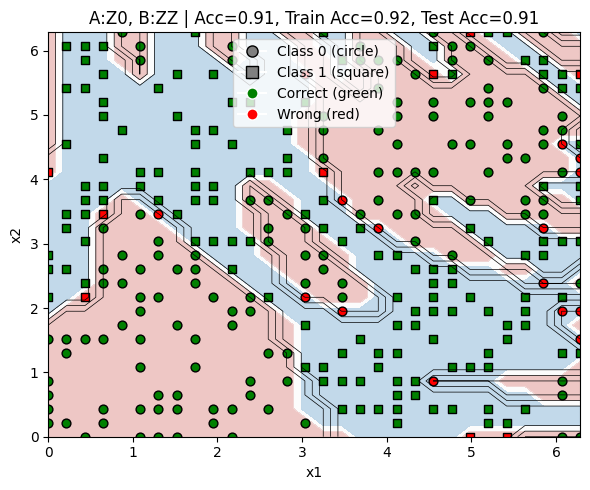

Training B(reupload=XX) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9054054054054054
Test Recall: 0.9115646258503401
Test F1: 0.9084745762711863
Time taken: 252.648987531662


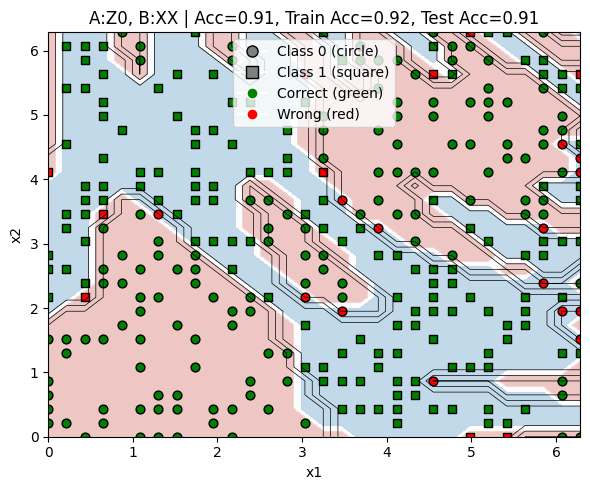

Training B(reupload=XZ) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 249.9316668510437


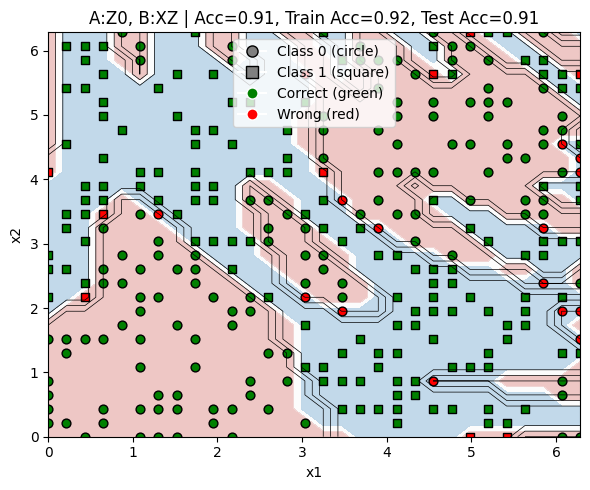

Training B(reupload=ZX) on data from A(reupload=Z0)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9054054054054054
Test Recall: 0.9115646258503401
Test F1: 0.9084745762711863
Time taken: 251.66632962226868


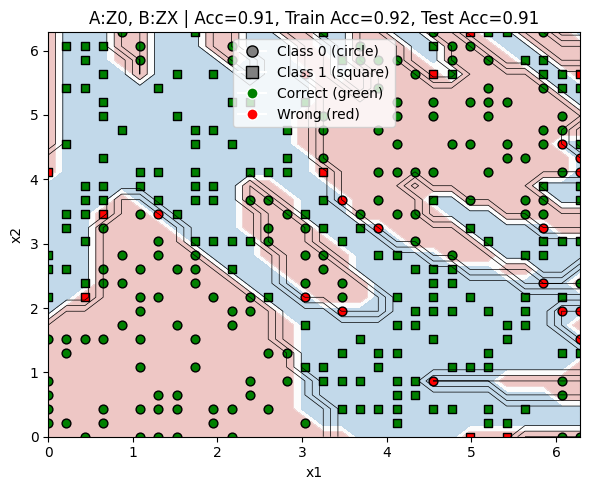

 17%|█▋        | 1/6 [25:16<2:06:20, 1516.16s/it]

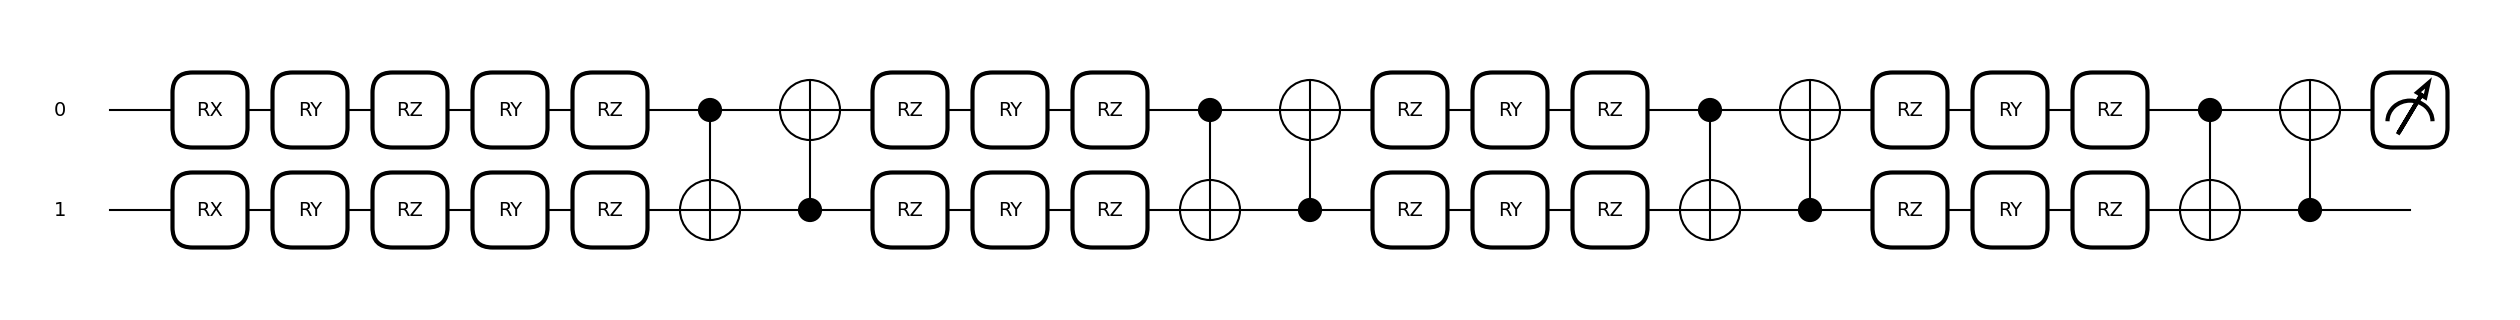

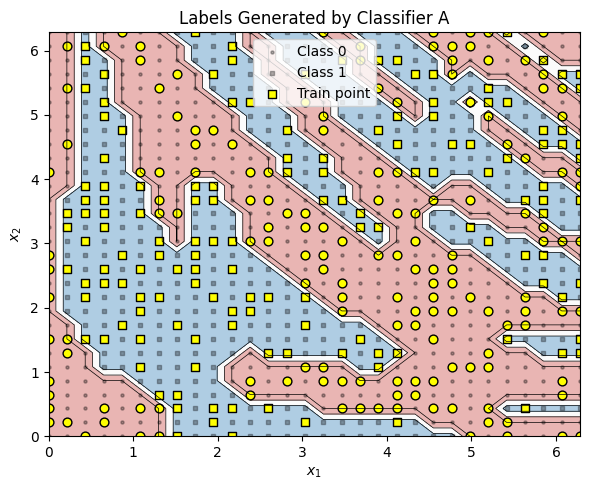

Training B(reupload=Z0) on data from A(reupload=X0)
Total Accuracy: 0.88
Train Accuracy: 0.91
Test Accuracy: 0.865
Test Precision: 0.8714285714285714
Test Recall: 0.8442906574394463
Test F1: 0.8576449912126538
Time taken: 243.7171037197113


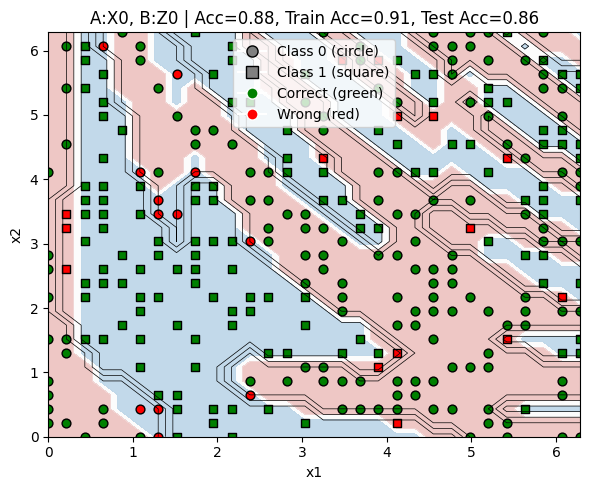

Training B(reupload=X0) on data from A(reupload=X0)
Total Accuracy: 0.8788888888888889
Train Accuracy: 0.91
Test Accuracy: 0.8633333333333333
Test Precision: 0.8709677419354839
Test Recall: 0.8408304498269896
Test F1: 0.8556338028169014
Time taken: 247.57617354393005


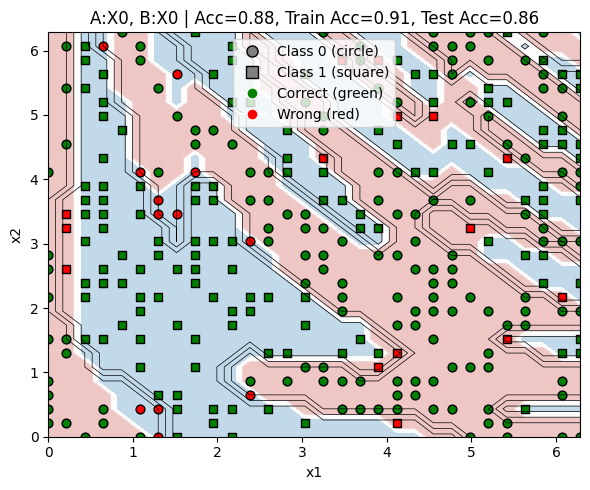

Training B(reupload=ZZ) on data from A(reupload=X0)
Total Accuracy: 0.88
Train Accuracy: 0.91
Test Accuracy: 0.865
Test Precision: 0.8714285714285714
Test Recall: 0.8442906574394463
Test F1: 0.8576449912126538
Time taken: 246.80665111541748


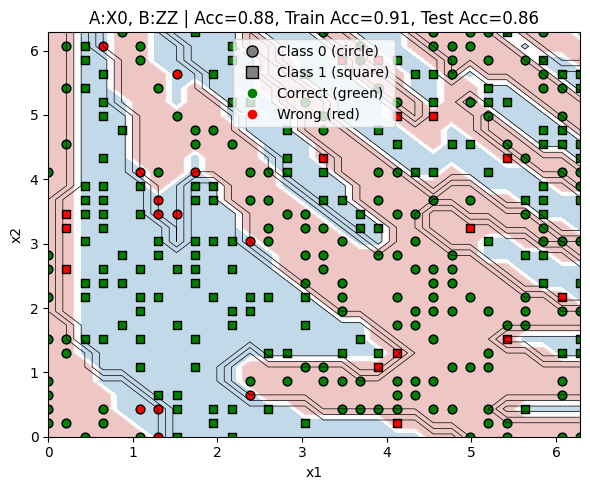

Training B(reupload=XX) on data from A(reupload=X0)
Total Accuracy: 0.88
Train Accuracy: 0.91
Test Accuracy: 0.865
Test Precision: 0.8714285714285714
Test Recall: 0.8442906574394463
Test F1: 0.8576449912126538
Time taken: 253.86351323127747


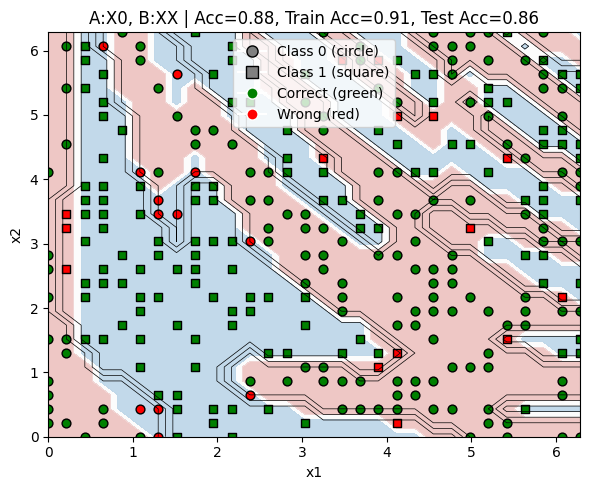

Training B(reupload=XZ) on data from A(reupload=X0)
Total Accuracy: 0.8811111111111111
Train Accuracy: 0.91
Test Accuracy: 0.8666666666666667
Test Precision: 0.8745519713261649
Test Recall: 0.8442906574394463
Test F1: 0.8591549295774649
Time taken: 253.5748393535614


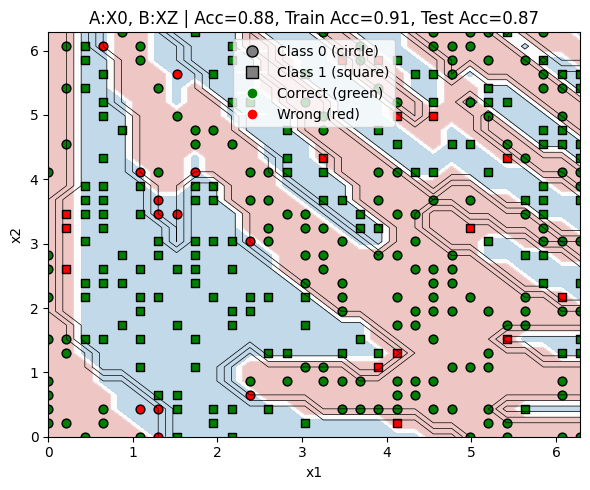

Training B(reupload=ZX) on data from A(reupload=X0)
Total Accuracy: 0.8788888888888889
Train Accuracy: 0.91
Test Accuracy: 0.8633333333333333
Test Precision: 0.8709677419354839
Test Recall: 0.8408304498269896
Test F1: 0.8556338028169014
Time taken: 252.4914288520813


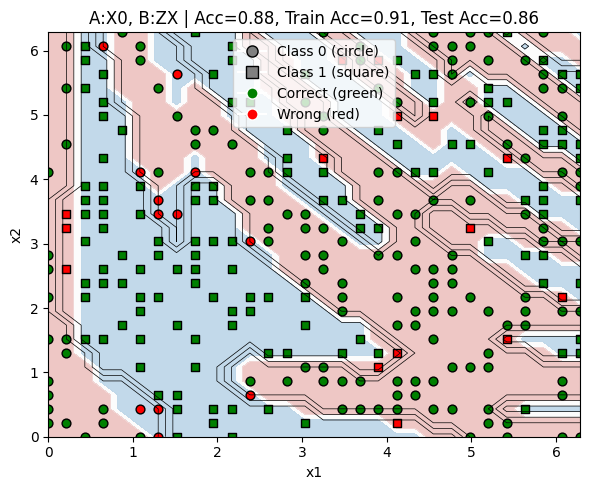

 33%|███▎      | 2/6 [50:22<1:40:41, 1510.41s/it]

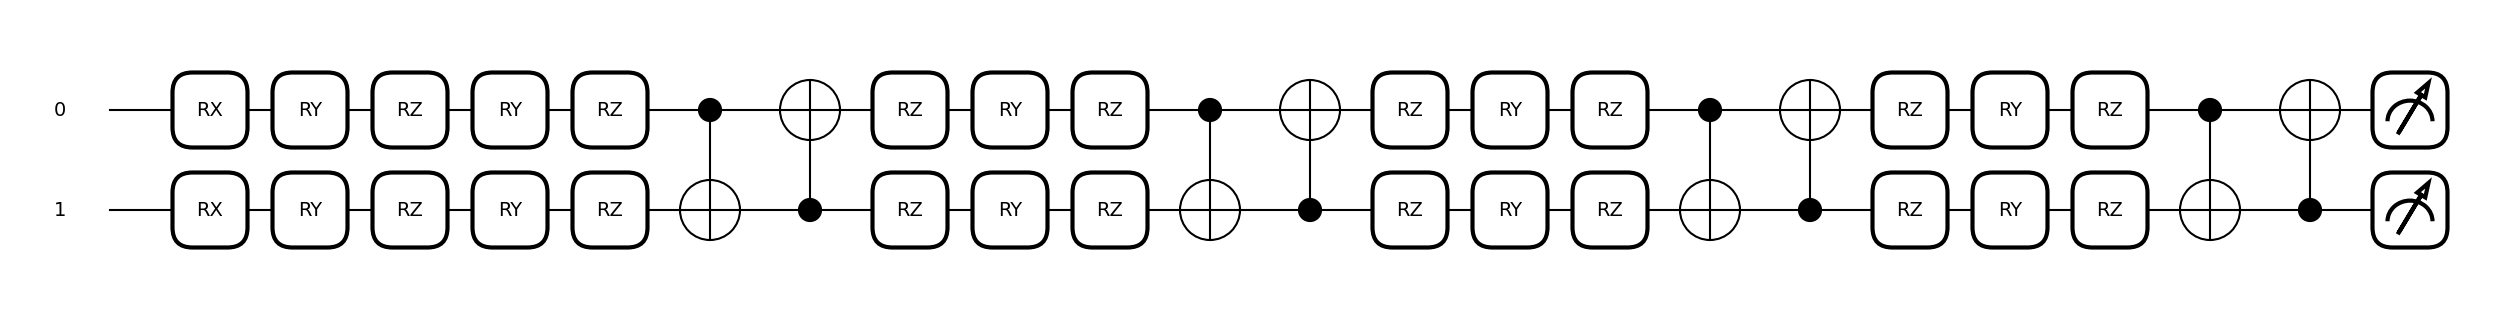

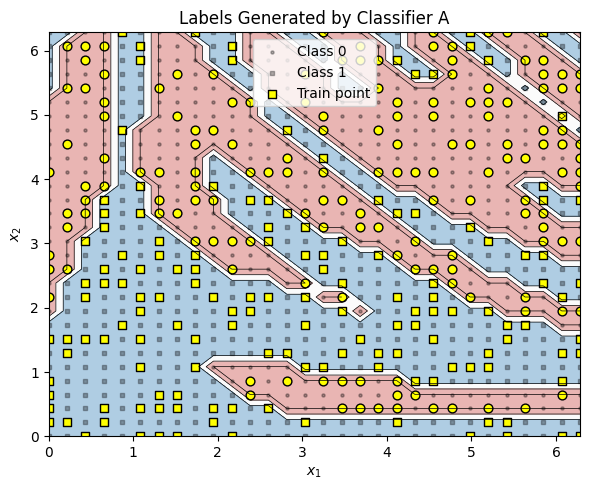

Training B(reupload=Z0) on data from A(reupload=ZZ)
Total Accuracy: 0.9122222222222223
Train Accuracy: 0.9333333333333333
Test Accuracy: 0.9016666666666666
Test Precision: 0.9056603773584906
Test Recall: 0.9085173501577287
Test F1: 0.9070866141732284
Time taken: 245.45821809768677


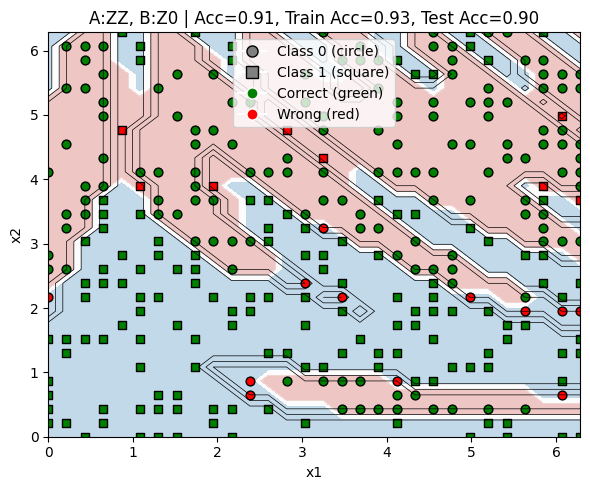

Training B(reupload=X0) on data from A(reupload=ZZ)
Total Accuracy: 0.9111111111111111
Train Accuracy: 0.9333333333333333
Test Accuracy: 0.9
Test Precision: 0.9028213166144201
Test Recall: 0.9085173501577287
Test F1: 0.9056603773584906
Time taken: 247.62599682807922


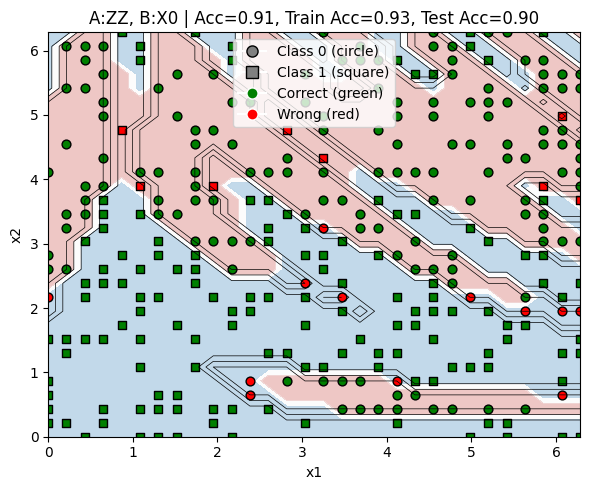

Training B(reupload=ZZ) on data from A(reupload=ZZ)
Total Accuracy: 0.9122222222222223
Train Accuracy: 0.93
Test Accuracy: 0.9033333333333333
Test Precision: 0.9085173501577287
Test Recall: 0.9085173501577287
Test F1: 0.9085173501577287
Time taken: 248.0574038028717


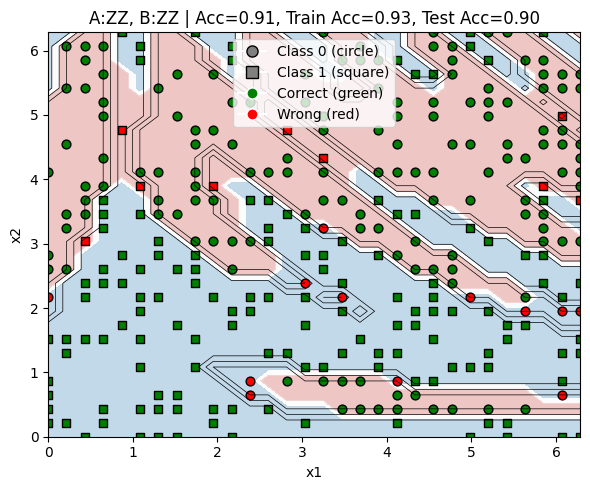

Training B(reupload=XX) on data from A(reupload=ZZ)
Total Accuracy: 0.9111111111111111
Train Accuracy: 0.93
Test Accuracy: 0.9016666666666666
Test Precision: 0.9056603773584906
Test Recall: 0.9085173501577287
Test F1: 0.9070866141732284
Time taken: 254.6586470603943


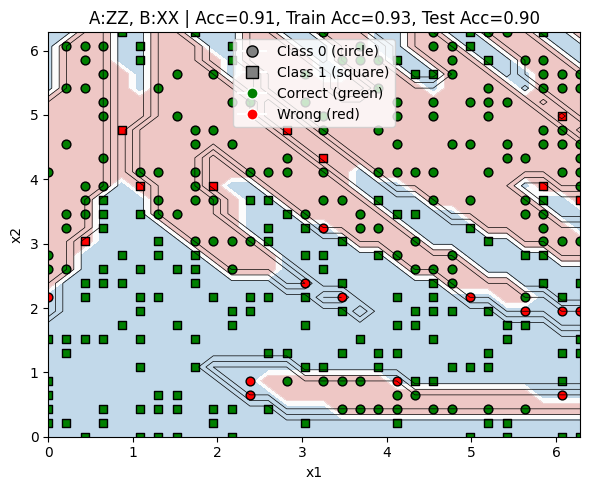

Training B(reupload=XZ) on data from A(reupload=ZZ)
Total Accuracy: 0.9111111111111111
Train Accuracy: 0.93
Test Accuracy: 0.9016666666666666
Test Precision: 0.9056603773584906
Test Recall: 0.9085173501577287
Test F1: 0.9070866141732284
Time taken: 251.50728154182434


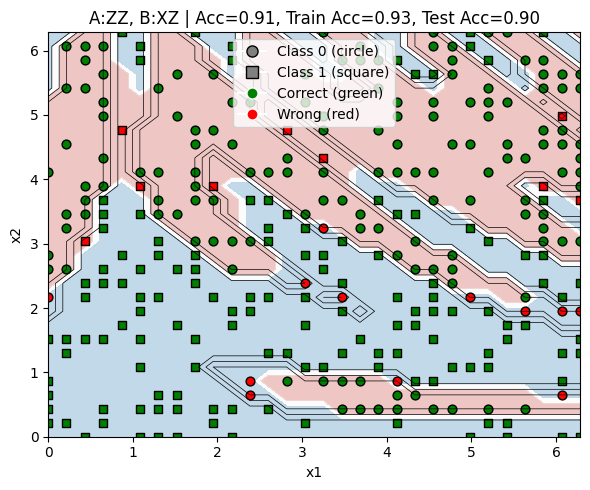

Training B(reupload=ZX) on data from A(reupload=ZZ)
Total Accuracy: 0.9122222222222223
Train Accuracy: 0.9333333333333333
Test Accuracy: 0.9016666666666666
Test Precision: 0.9056603773584906
Test Recall: 0.9085173501577287
Test F1: 0.9070866141732284
Time taken: 252.14143753051758


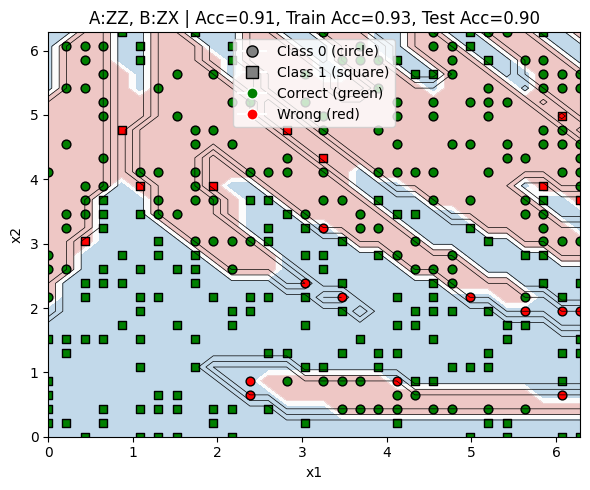

 50%|█████     | 3/6 [1:15:30<1:15:28, 1509.42s/it]

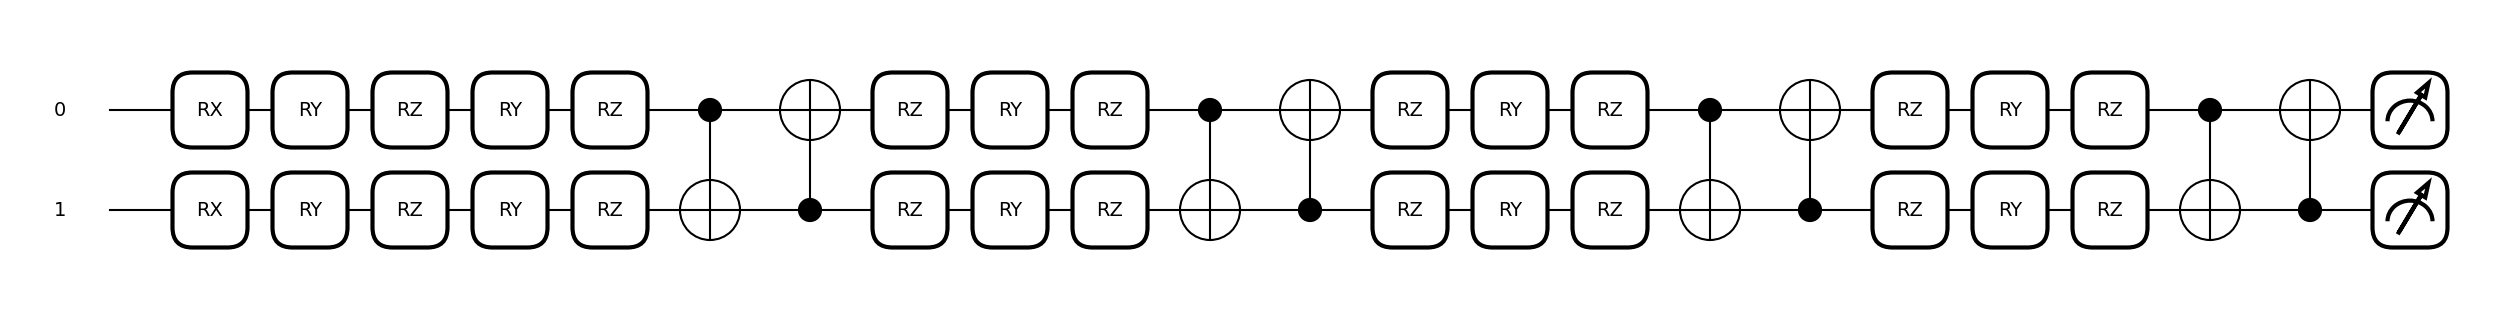

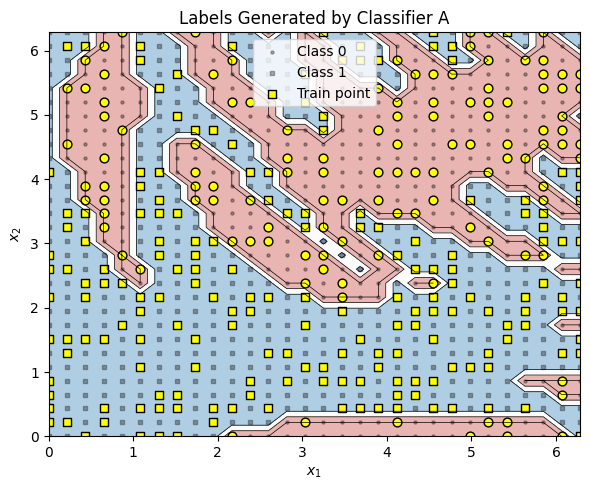

Training B(reupload=Z0) on data from A(reupload=XX)
Total Accuracy: 0.8533333333333334
Train Accuracy: 0.8866666666666667
Test Accuracy: 0.8366666666666667
Test Precision: 0.912751677852349
Test Recall: 0.7906976744186046
Test F1: 0.8473520249221184
Time taken: 245.1504476070404


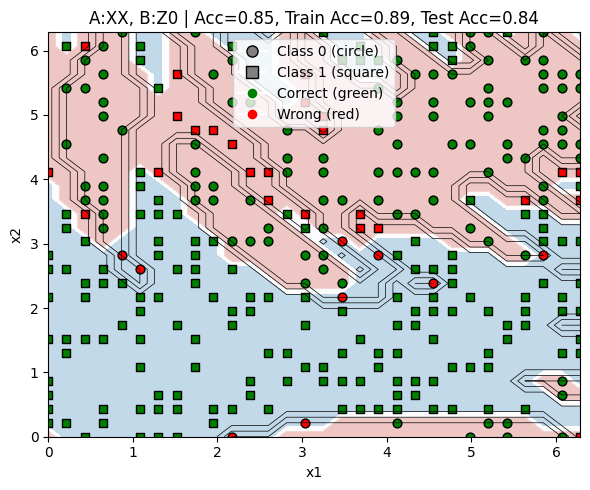

Training B(reupload=X0) on data from A(reupload=XX)
Total Accuracy: 0.8533333333333334
Train Accuracy: 0.8866666666666667
Test Accuracy: 0.8366666666666667
Test Precision: 0.912751677852349
Test Recall: 0.7906976744186046
Test F1: 0.8473520249221184
Time taken: 248.2162389755249


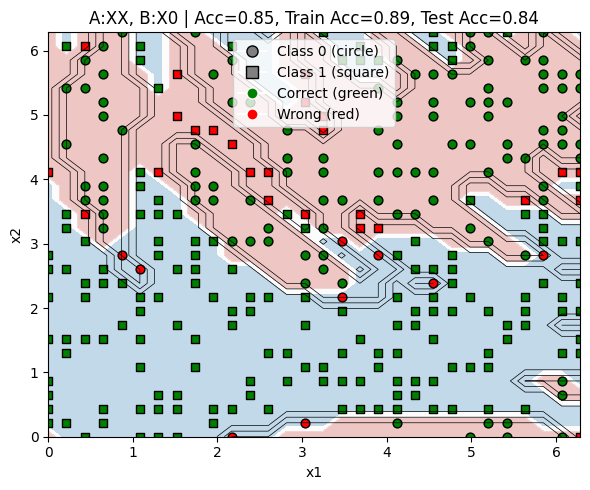

Training B(reupload=ZZ) on data from A(reupload=XX)
Total Accuracy: 0.8533333333333334
Train Accuracy: 0.8866666666666667
Test Accuracy: 0.8366666666666667
Test Precision: 0.912751677852349
Test Recall: 0.7906976744186046
Test F1: 0.8473520249221184
Time taken: 249.37271189689636


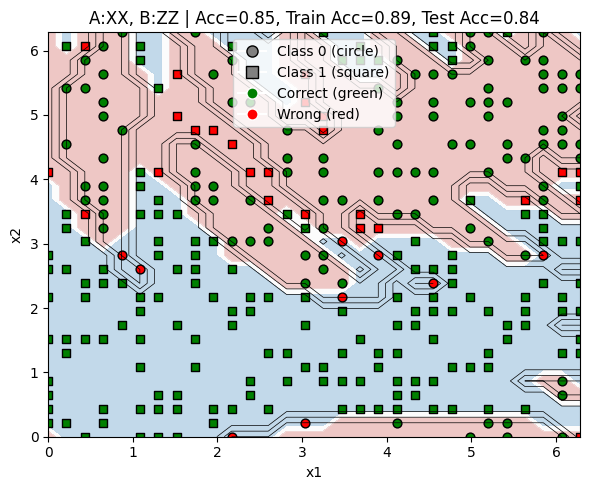

Training B(reupload=XX) on data from A(reupload=XX)
Total Accuracy: 0.8544444444444445
Train Accuracy: 0.89
Test Accuracy: 0.8366666666666667
Test Precision: 0.912751677852349
Test Recall: 0.7906976744186046
Test F1: 0.8473520249221184
Time taken: 253.9080696105957


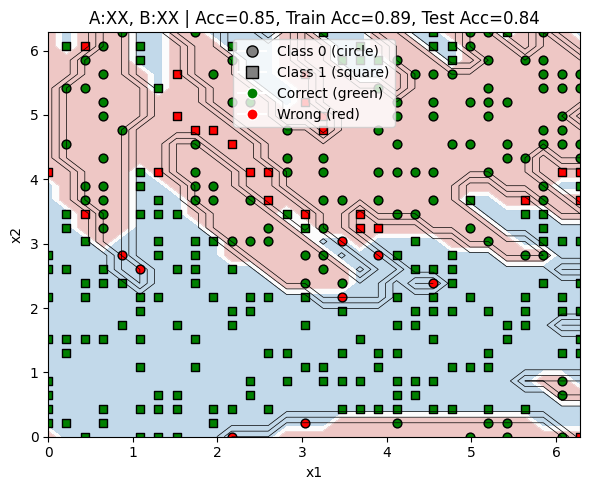

Training B(reupload=XZ) on data from A(reupload=XX)
Total Accuracy: 0.8544444444444445
Train Accuracy: 0.89
Test Accuracy: 0.8366666666666667
Test Precision: 0.912751677852349
Test Recall: 0.7906976744186046
Test F1: 0.8473520249221184
Time taken: 252.08464241027832


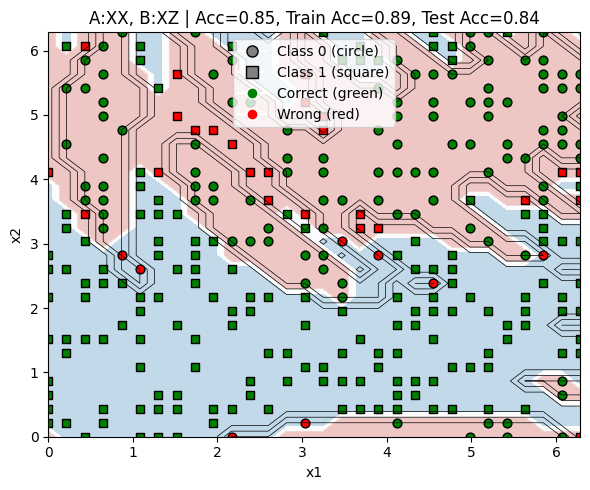

Training B(reupload=ZX) on data from A(reupload=XX)
Total Accuracy: 0.8577777777777778
Train Accuracy: 0.8966666666666666
Test Accuracy: 0.8383333333333334
Test Precision: 0.9130434782608695
Test Recall: 0.7936046511627907
Test F1: 0.8491446345256609
Time taken: 251.62110829353333


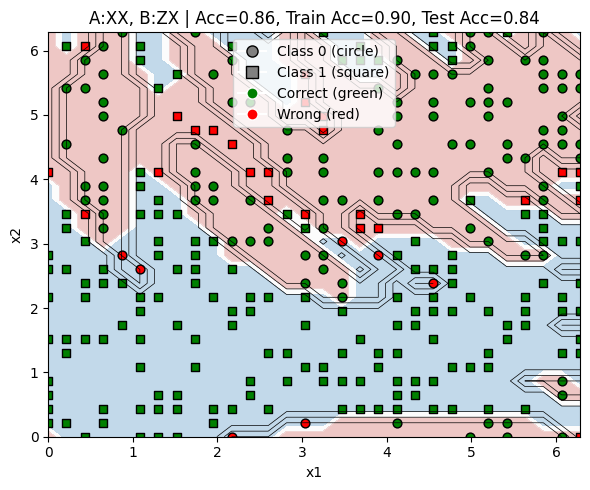

 67%|██████▋   | 4/6 [1:40:39<50:18, 1509.26s/it]  

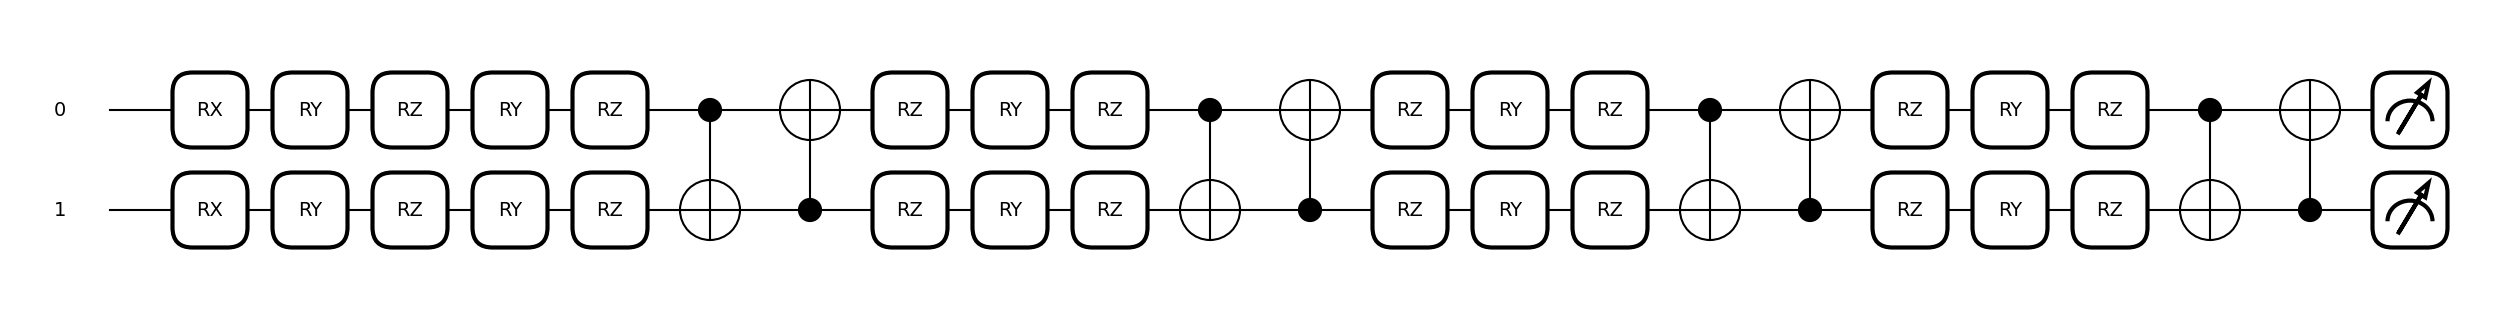

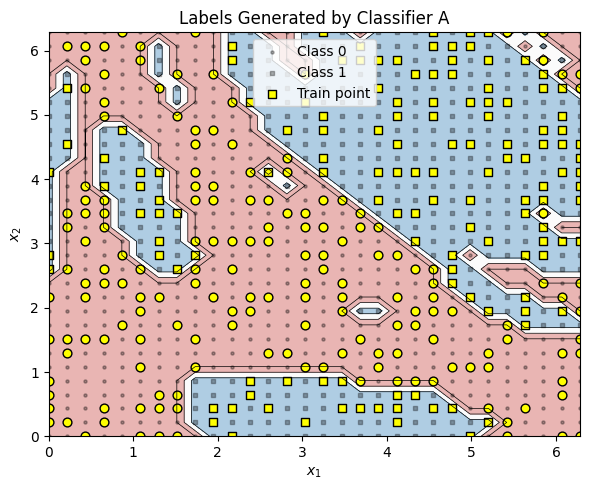

Training B(reupload=Z0) on data from A(reupload=XZ)
Total Accuracy: 0.9433333333333334
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9366666666666666
Test Precision: 0.9148936170212766
Test Recall: 0.9485294117647058
Test F1: 0.9314079422382672
Time taken: 245.23759818077087


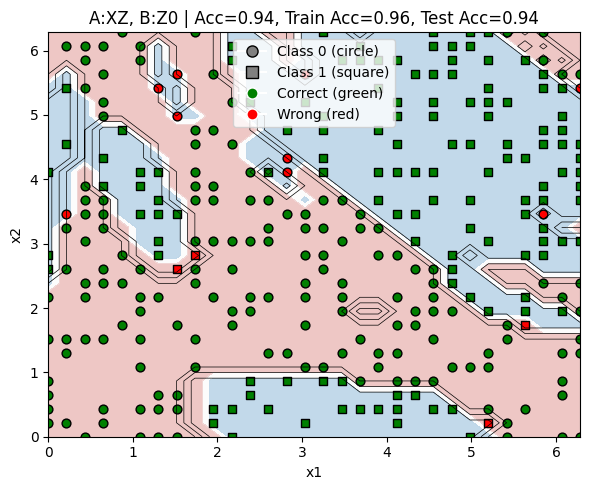

Training B(reupload=X0) on data from A(reupload=XZ)
Total Accuracy: 0.9444444444444444
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9383333333333334
Test Precision: 0.9151943462897526
Test Recall: 0.9522058823529411
Test F1: 0.9333333333333332
Time taken: 248.27041721343994


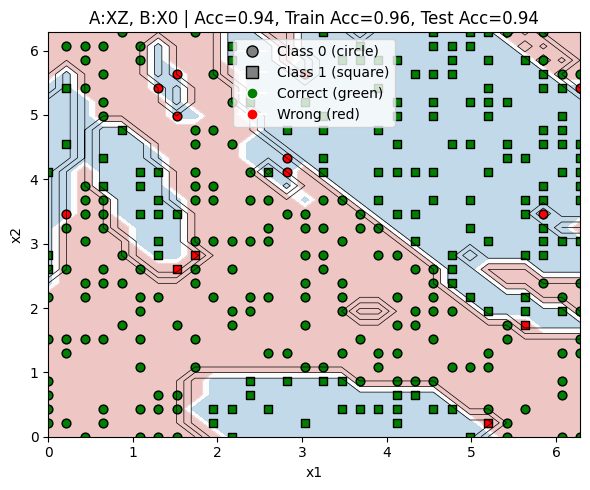

Training B(reupload=ZZ) on data from A(reupload=XZ)
Total Accuracy: 0.9433333333333334
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9366666666666666
Test Precision: 0.9148936170212766
Test Recall: 0.9485294117647058
Test F1: 0.9314079422382672
Time taken: 248.68706154823303


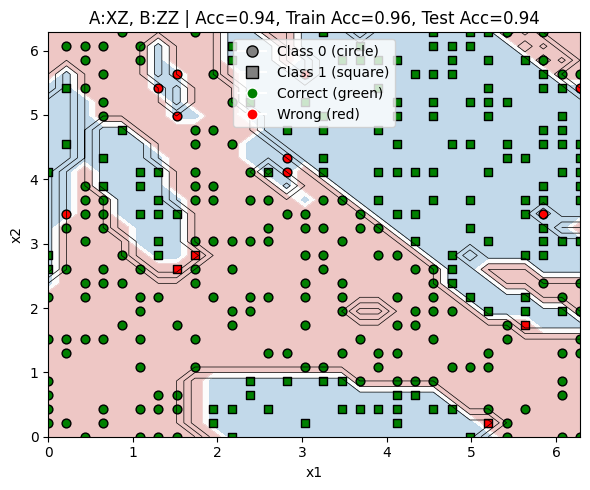

Training B(reupload=XX) on data from A(reupload=XZ)
Total Accuracy: 0.9433333333333334
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9366666666666666
Test Precision: 0.9148936170212766
Test Recall: 0.9485294117647058
Test F1: 0.9314079422382672
Time taken: 254.216406583786


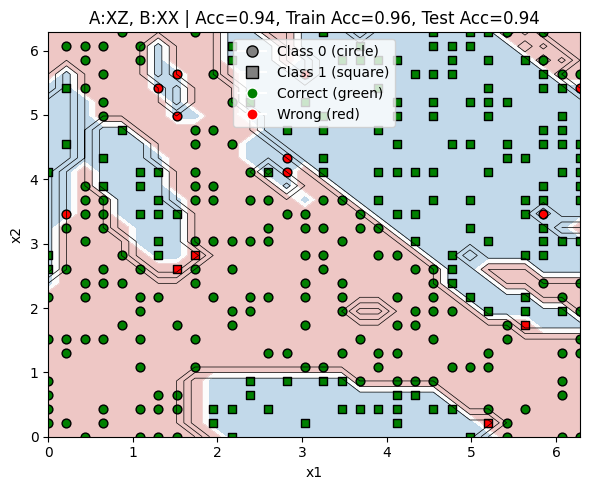

Training B(reupload=XZ) on data from A(reupload=XZ)
Total Accuracy: 0.9444444444444444
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9383333333333334
Test Precision: 0.9181494661921709
Test Recall: 0.9485294117647058
Test F1: 0.9330922242314647
Time taken: 252.15803956985474


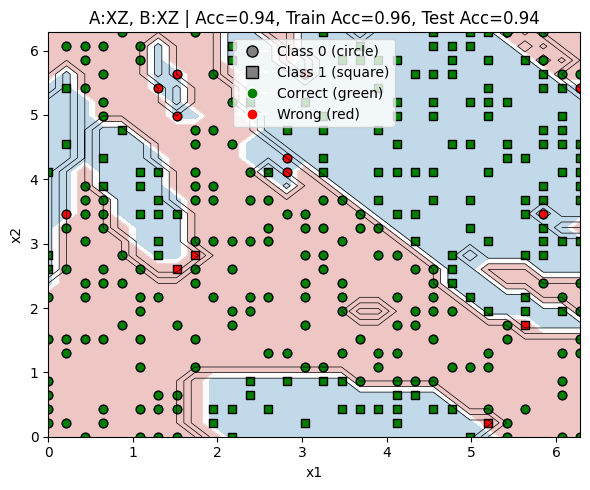

Training B(reupload=ZX) on data from A(reupload=XZ)
Total Accuracy: 0.9444444444444444
Train Accuracy: 0.9566666666666667
Test Accuracy: 0.9383333333333334
Test Precision: 0.9181494661921709
Test Recall: 0.9485294117647058
Test F1: 0.9330922242314647
Time taken: 251.78734183311462


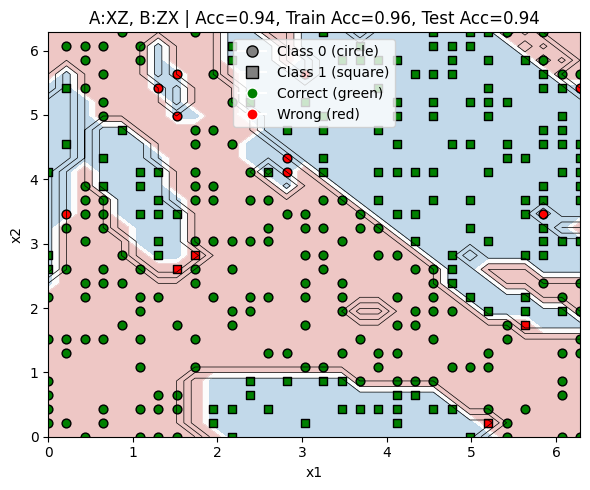

 83%|████████▎ | 5/6 [2:05:49<25:09, 1509.26s/it]

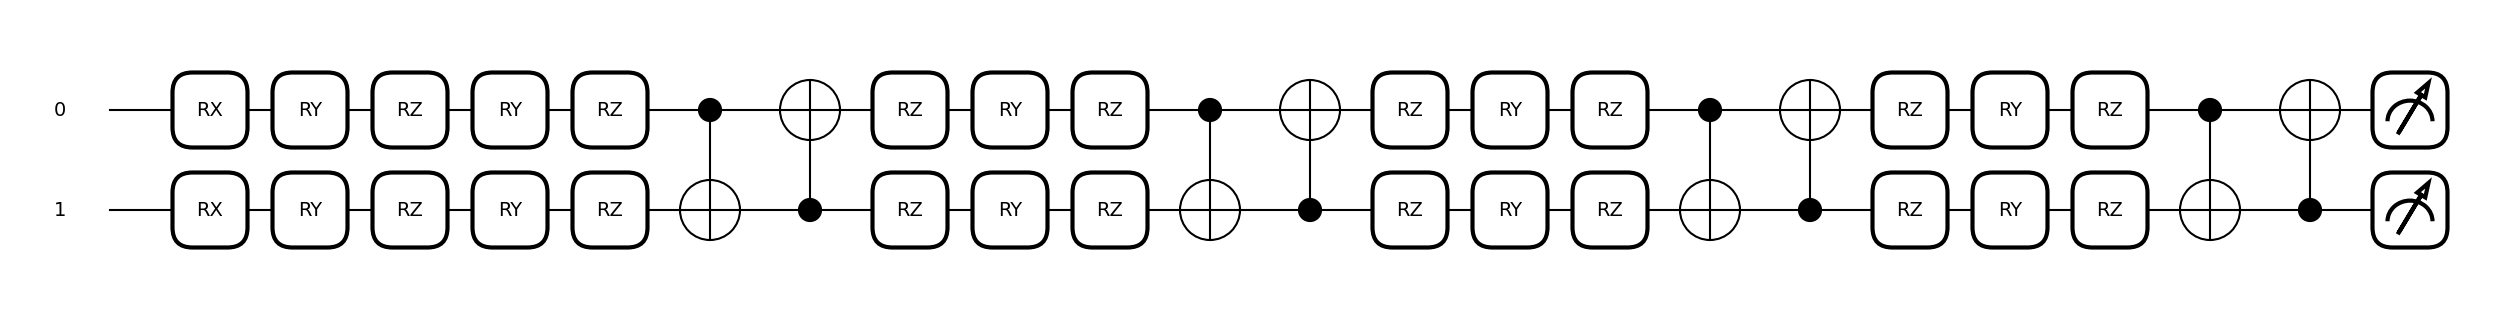

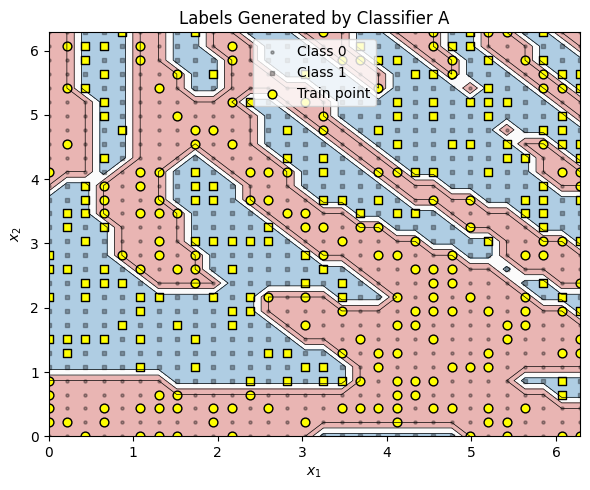

Training B(reupload=Z0) on data from A(reupload=ZX)
Total Accuracy: 0.9088888888888889
Train Accuracy: 0.9233333333333333
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 244.45786333084106


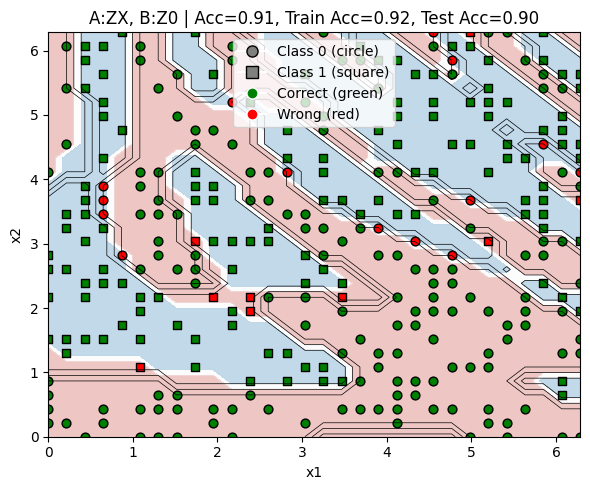

Training B(reupload=X0) on data from A(reupload=ZX)
Total Accuracy: 0.91
Train Accuracy: 0.9266666666666666
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 248.59147763252258


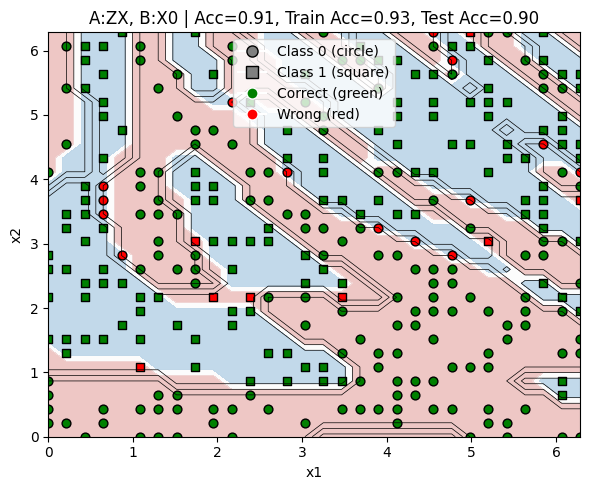

Training B(reupload=ZZ) on data from A(reupload=ZX)
Total Accuracy: 0.91
Train Accuracy: 0.9266666666666666
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 248.4620020389557


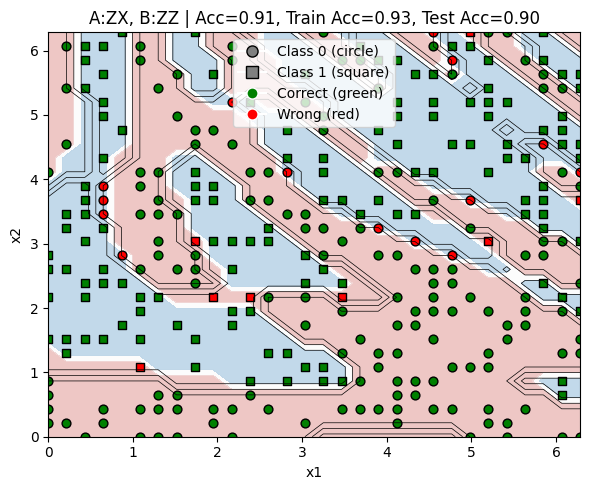

Training B(reupload=XX) on data from A(reupload=ZX)
Total Accuracy: 0.91
Train Accuracy: 0.9266666666666666
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 255.08398938179016


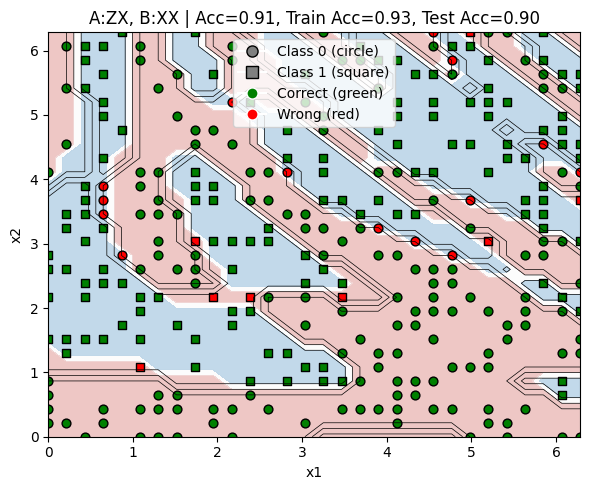

Training B(reupload=XZ) on data from A(reupload=ZX)
Total Accuracy: 0.9088888888888889
Train Accuracy: 0.9233333333333333
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 251.748113155365


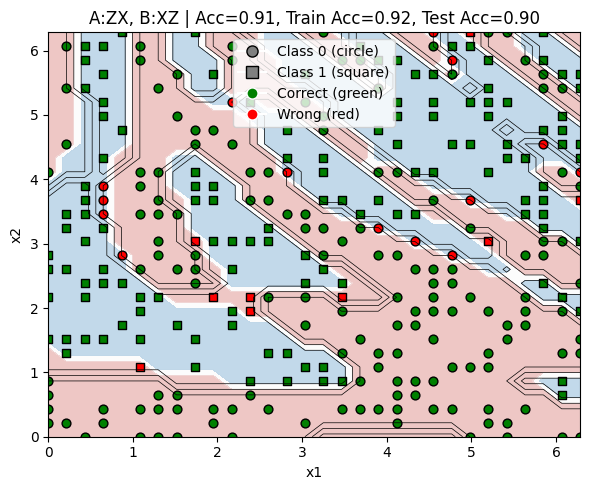

Training B(reupload=ZX) on data from A(reupload=ZX)
Total Accuracy: 0.91
Train Accuracy: 0.9266666666666666
Test Accuracy: 0.9016666666666666
Test Precision: 0.9014598540145985
Test Recall: 0.8853046594982079
Test F1: 0.8933092224231465
Time taken: 253.03298258781433


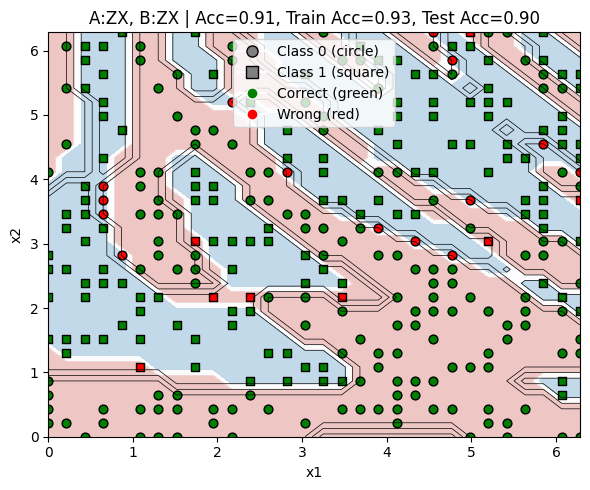

100%|██████████| 6/6 [2:30:59<00:00, 1509.91s/it]


In [10]:

for name_A,depth_A in tqdm(depths.items()):
    # Generate labels using fixed A
    devA = qml.device("default.qubit", wires=n_qubits)
    weights_A = np.random.uniform(0, 2*np.pi, size=(4, n_qubits, 3))
    circuit_A = create_qnode(4, weights_A, devA, 1, depth_A)
    labels_A = generate_labels(circuit_A, inputs)
    y_train = torch.tensor(labels_A[train_idx], dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(labels_A[test_idx], dtype=torch.float32).unsqueeze(1)
    qml.drawer.draw_mpl(circuit_A)([0, 1]);
    
    plot_generator_A(labels_A, "Labels Generated by Classifier A", X=inputs, train_idx=train_idx)
    for name_B,depth_B in tqdm(depths.items()):
        print(f"Training B(reupload={name_B}) on data from A(reupload={name_A})")
        devB = qml.device("default.qubit", wires=n_qubits)
        model_B = get_torch_model(4, devB, 1,depth_B)
        start_time = time.time()
        trained_model = train_model(model_B, X_train, y_train)

        # Evaluate model
        with torch.no_grad():
            preds = torch.stack([trained_model(x) for x in torch.tensor(inputs, dtype=torch.float32)]).numpy().flatten()
            pred_labels = (preds > 0).astype(int)
            
        train_preds = pred_labels[train_idx]
        test_preds = pred_labels[test_idx]

        acc = accuracy_score(labels_A, pred_labels)
        
        train_acc = accuracy_score(labels_A[train_idx], train_preds)
        test_acc = accuracy_score(labels_A[test_idx], test_preds)
        precision = precision_score(labels_A[test_idx], test_preds)
        recall = recall_score(labels_A[test_idx], test_preds)
        f1 = f1_score(labels_A[test_idx], test_preds)
        # Plot
        title = f"A:{name_A}, B:{name_B} | Acc={acc:.2f}, Train Acc={train_acc:.2f}, Test Acc={test_acc:.2f}"
        print("Total Accuracy:", acc)
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        print("Test Precision:", precision)
        print("Test Recall:", recall)
        print("Test F1:", f1)
        print("Time taken:", time.time() - start_time)
        plot_results(labels_A, pred_labels, title, inputs, train_idx)
        
        results.append((name_A, name_B, acc, train_acc, test_acc))




In [11]:
def get_key_by_value(d, val):
    for k, v in d.items():
        if v is val:
            return k
    return None


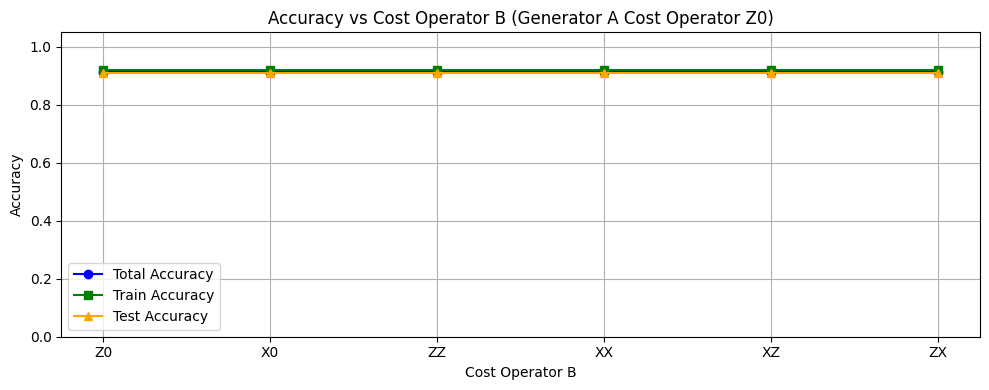

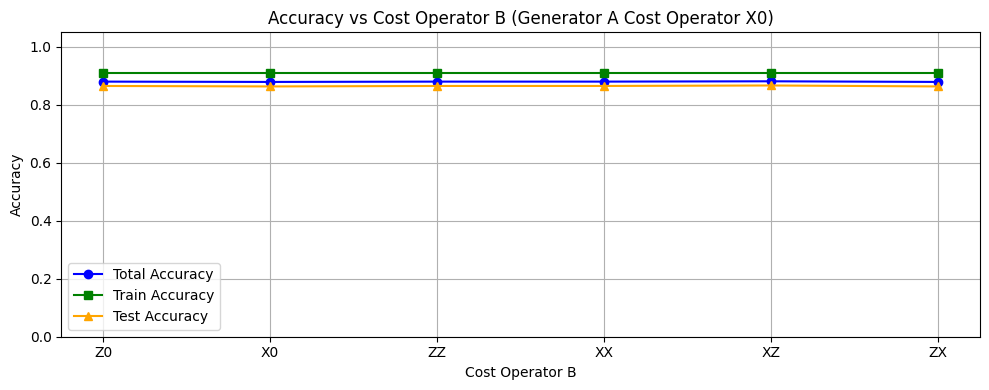

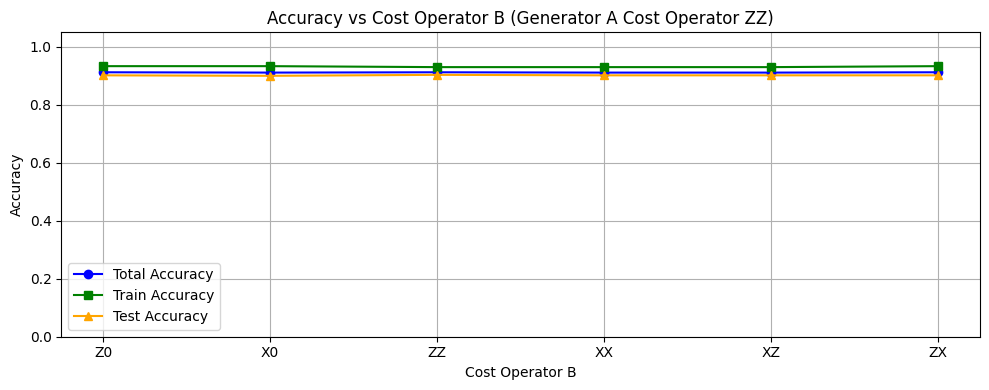

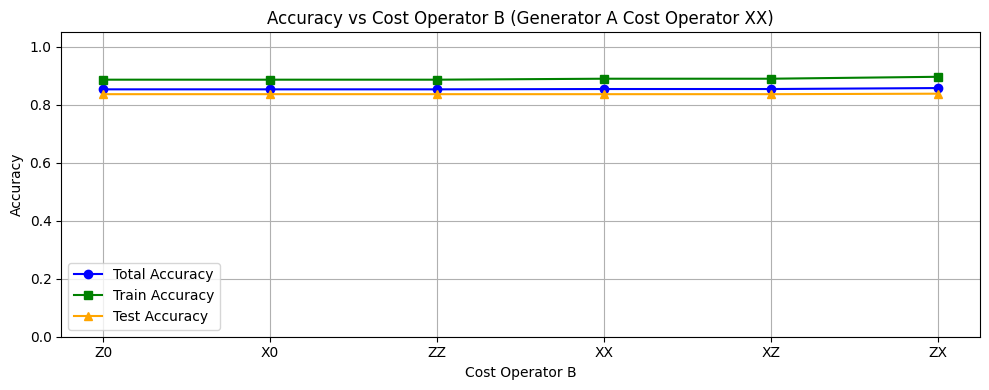

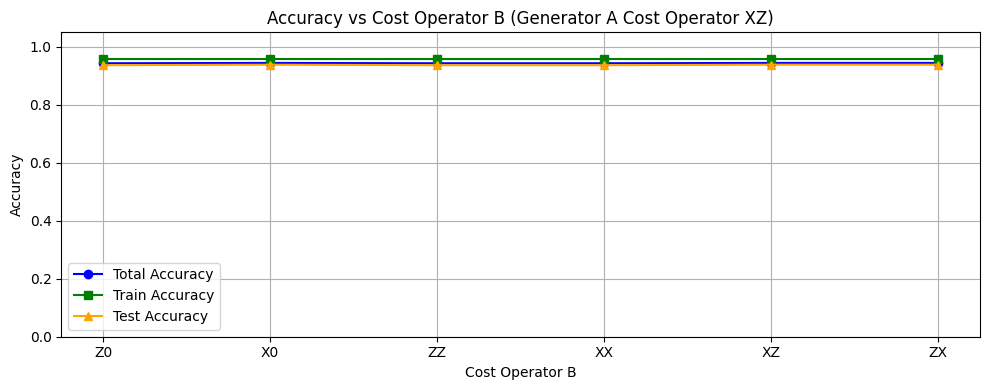

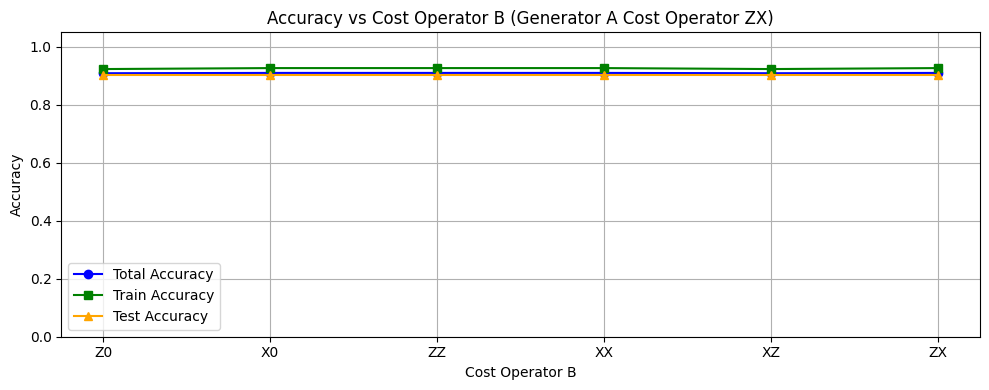

In [12]:

# Updated DataFrame with new 

df_results = pd.DataFrame(results, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Cost Operator B (Generator A Cost Operator {depth_A})")
    plt.xlabel("Cost Operator B")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
print("done")

done


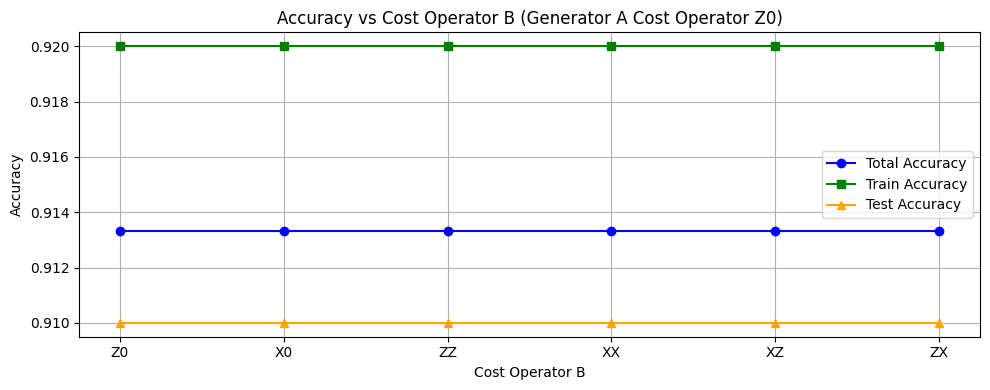

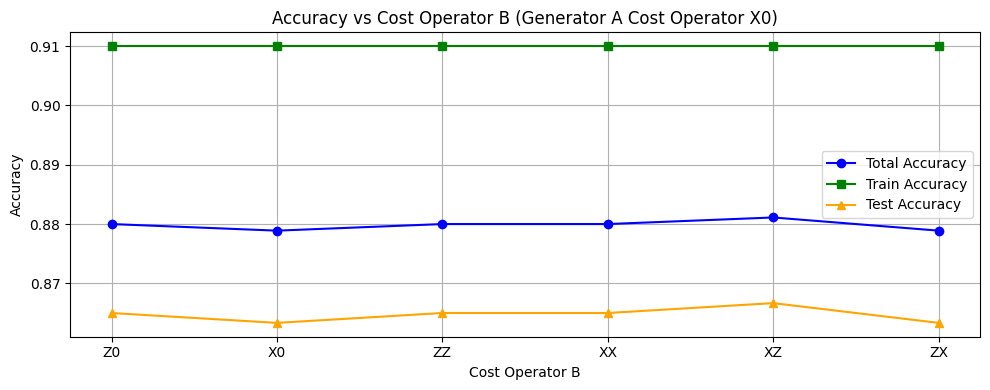

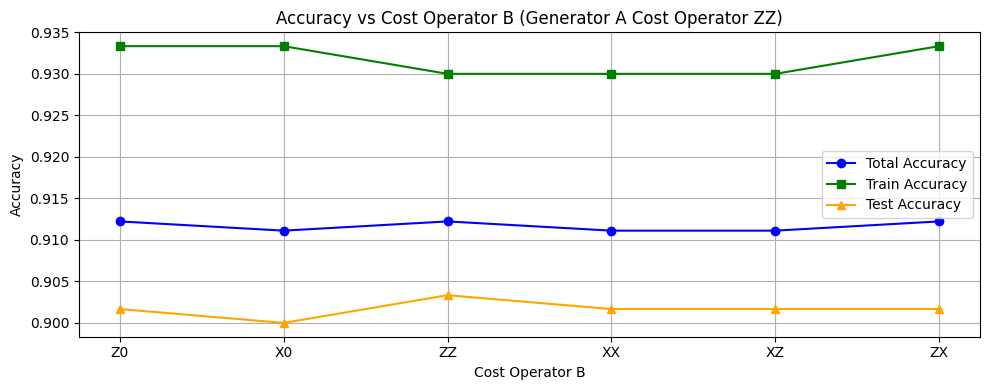

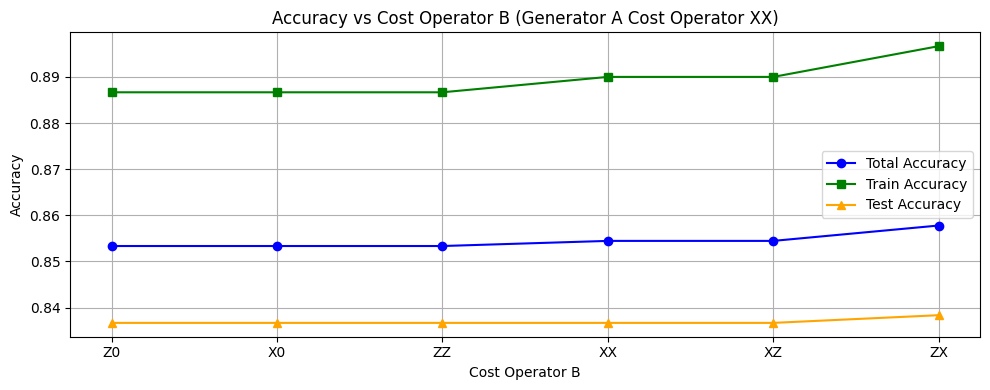

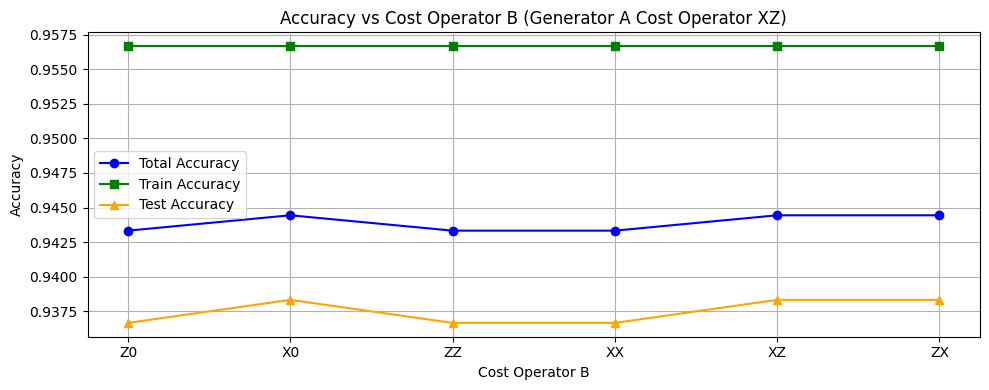

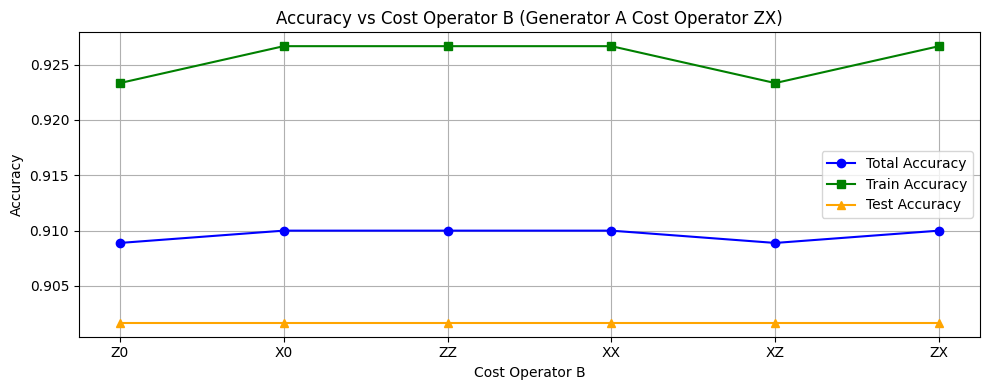

In [14]:

# Updated DataFrame with new 

df_results = pd.DataFrame(results, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Cost Operator B (Generator A Cost Operator {depth_A})")
    plt.xlabel("Cost Operator B")
    plt.ylabel("Accuracy")
    # plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
